- 目的：產生論文 4.4.2 圖檔
- 作法：修改 ar1-6(T=3) Setting 當中的五個 scenarios

In [436]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


# 自訂 function 可重新 reload
from importlib import reload
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *

from scipy.stats import norm


In [437]:
def pred_modify(pred, case):
    if case == 'original': # original
        pred = pred
    elif case == 'narrow': # too narrow
        pred = 0.5*(pred-np.mean(pred, axis=0)) + np.mean(pred, axis=0)
    elif case == 'wide':
        pred = 2*(pred-np.mean(pred, axis=0)) + np.mean(pred, axis=0)
    elif case == 'under': # under estimation case
        pred = pred - 3
    elif case =='over': # over estimation case
        pred = pred + 3
    return pred

# Setting

In [438]:
interval_case = "over"  # case: original, narrow, wide, under, over

# Read data

In [439]:
main_folder_path = "/home/hchuang/Documents/Project/"

# I2
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_I2/"
pred_data_I2 = read_multiple_imputations(folder_path, 1)
true_data_I2 = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data_I2, shape: {pred_data_I2.shape}")
print(f"true_data_I2, shape: {true_data_I2.shape}")

# test data
folder_path = main_folder_path + "SSSD_CP/src/results/ar1/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_test/"
pred_data_test = read_multiple_imputations(folder_path, 1)
true_data_test = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

print(f"pred_data_test, shape: {pred_data_test.shape}")
print(f"true_data_test, shape: {true_data_test.shape}")

# test data all (whole series) for calculating true conditional distribution 0.8*y_2 in Comparison section
true_data_all_test = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/AR/test_ar1_1000_3.npy')

pred_data_I2, shape: (100, 10000, 1, 1)
true_data_I2, shape: (10000, 1, 1)
pred_data_test, shape: (100, 1000, 1, 1)
true_data_test, shape: (1000, 1, 1)


# Assumed Model

In [440]:
# modify predictions
pred_data_I2 = pred_modify(pred_data_I2, case = interval_case)
pred_data_test = pred_modify(pred_data_test, case = interval_case)

# prediction interval and coverage rate of assuming model
L_star_model, U_star_model = pred_interval(pred_data_test, beta = 0.05)
CR_test_model = coverage_rate(L_star_model, U_star_model, true_data_test)

# Method 1: CPI_B

In [441]:
# Compute E*
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)
# L, U = case_setting(L, U, case = interval_case) # modify interval

E_star = compute_E_star(L, U, true_data, alpha = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)

print(f'E_star_L: {E_star}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

# adjust PI
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
# L, U = case_setting(L,U, case = interval_case)  # modify interval
L_star_both, U_star_both = adjust_PI(L, U, E_star)
print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star_both, U_star_both, true_data)}')

CR_test_both = coverage_rate(L_star_both, U_star_both, true_data)

E_star_L: [[2.9838596]]
I2 CR: [[0.1611]]
I2 adjusted CR: [[0.95]]
test CR: [[0.154]]
test adjusted CR: [[0.95]]


# Method 2: CPI_E

In [442]:
# Compute E*
pred_data = pred_data_I2
true_data = true_data_I2

L, U = pred_interval(pred_data, beta = 0.05)

E_star_L, E_star_U = compute_E_star_separate(L, U, true_data, alpha = 0.025)
L_star, U_star = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'E_star_L: {E_star_L}, E_star_U: {E_star_U}')
print(f'I2 CR: {coverage_rate(L, U, true_data)}')
print(f'I2 adjusted CR: {coverage_rate(L_star, U_star, true_data)}')

# adjust PI
pred_data = pred_data_test
true_data = true_data_test

L, U = pred_interval(pred_data, beta = 0.05)
L_star_each, U_star_each = adjust_PI_separate(L, U, E_star_L, E_star_U)

print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star_each, U_star_each, true_data)}')
CR_test_each = coverage_rate(L_star_each, U_star_each, true_data)

E_star_L: [[3.334038]], E_star_U: [[-2.70655789]]
I2 CR: [[0.1611]]
I2 adjusted CR: [[0.95]]
test CR: [[0.154]]
test adjusted CR: [[0.955]]


# Method 3: SCP

In [443]:
# compute E
pred_data = np.median(pred_data_I2, axis = 0)

# pred_data = median_pred_data_I2 + 3
true_data = true_data_I2

E_star_exd = compute_E_star_SCP(pred = pred_data, true = true_data, alpha = 0.05)

L = pred_data - E_star_exd
U = pred_data + E_star_exd

# compute conformal prediction 
pred_data = np.median(pred_data_test, axis = 0)

# pred_data = median_pred_data_test + 3
true_data = true_data_test 

L, U = pred_interval(pred_data_test+3, beta = 0.05)
# L, U = case_setting(L,U, case = interval_case)  # modify interval
L_star_scp = pred_data - E_star_exd
U_star_scp = pred_data + E_star_exd

print(f'test CR: {coverage_rate(L, U, true_data)}')
print(f'test adjusted CR: {coverage_rate(L_star_scp, U_star_scp, true_data)}')
CR_test_scp = coverage_rate(L_star_scp, U_star_scp, true_data)

test CR: [[0.]]
test adjusted CR: [[0.946]]


# Comparison

In [444]:
import os
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /home/hchuang/Documents/Project/SSSD_CP/src


In [445]:
# 指定保存的文件夹
folder = '/home/hchuang/Documents/Project/SSSD_CP/src/results/ar1/ar1-6/T200_beta00.0001_betaT0.02/'
foldername = 'figures/'
# 检查文件夹是否存在，如果不存在，则创建
if not os.path.exists(folder+foldername):
    os.makedirs(folder+foldername)

## 單張圖分開畫

### Intervals per test data

In [446]:
# for index in range(1):
#     L_true = true_data_all_test[index,1,0]*0.8 - 1.96
#     U_true = true_data_all_test[index,1,0]*0.8 + 1.96

#     L_model = L_star_model[index,0,0]
#     U_model = U_star_model[index,0,0]

#     L_scp = L_star_scp[index,0,0]
#     U_scp = U_star_scp[index,0,0]

#     L_both = L_star_both[index,0,0]
#     U_both = U_star_both[index,0,0]

#     L_each = L_star_each[index,0,0]
#     U_each = U_star_each[index,0,0]
#     # 定義區間的上下界和名稱
#     intervals = {
#         'True': (L_true, U_true),
#         'Model': (L_model, U_model),
#         'SCP': (L_scp, U_scp),
#         'Cal_both': (L_both, U_both),
#         'Cal_each': (L_each, U_each)
#     }

#     # 調整圖形去掉 y 軸的那條線
#     plt.figure(figsize=(8, 4))

#     # 繪製區間線條和圓點
#     for i, (label, (start, end)) in enumerate(intervals.items()):
#         k = len(intervals) - i - 1
#         plt.plot([start, end], [k, k], marker='|', markersize=8)  # 繪製線和端點
#         plt.text(-8, k, label, va='center', ha='right', fontsize=20)  # 左側對齊區間名稱

#     # 隱藏 y 軸
#     plt.gca().yaxis.set_visible(False)  # 隱藏 y 軸的數值
#     # plt.gca().spines['left'].set_visible(False)  # 隱藏 y 軸的線

#     # 添加 x 軸網格線
#     plt.grid(True, axis='x', linestyle='--', alpha=0.6)

#     # 調整 x 軸範圍
#     plt.xlim(-10, 10)
#     plt.ylim(-1, len(intervals))  # 調整 y 軸範圍（實際上不顯示）

#     # 設定標題
#     plt.title('')

#     plt.tight_layout()
#     plt.show()


### Distribution per test data

In [447]:

# index = 0

# # 第一部分：畫出 Normal Distribution
# mean = true_data_all_test[index,1,0].flatten()*0.8  # 設定平均值
# std_dev = 1  # 設定標準差

# x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)  # X 軸範圍
# y = norm.pdf(x, mean, std_dev)  # 使用正態分佈的概率密度函數 (PDF)

# # 第二部分：畫出 Histogram
# data = pred_data_test[:,index,0,0].flatten()  # 假設的隨機數據，符合標準正態分佈

# # 繪製圖形
# plt.figure(figsize=(8, 4))

# # 畫出正態分佈曲線
# plt.plot(x, y, label='Conditional Distribution of Test Data', color='blue', alpha=0.5)  # 添加透明度

# # 畫出直方圖
# plt.hist(data, bins=20, density=True, alpha=0.6, label='Histogram of Predictions', color='orange')

# # 添加垂直線在平均值位置
# plt.axvline(x=true_data_test[index,0,0], color='blue', linestyle='--', label='Test Data')


# # 設置標題和標籤
# plt.title('')
# plt.xlabel('')
# plt.ylabel('')
# plt.legend()

# # 顯示圖形
# plt.tight_layout()
# plt.show()


## Intervals per test data

In [448]:
true_data_all_test.shape[1]

3

In [449]:
intervals

{'True': (-2.497222778396311, 1.422777221603689),
 'EQPI': (-5.323402512073517, -1.5924087494611754),
 'CPI_B': (-8.265965863301068, 1.350154601766376),
 'CPI_E': (-2.6574403983717847, 1.701033356499164),
 'SCP': (-8.175932251412867, 1.585316025216577)}

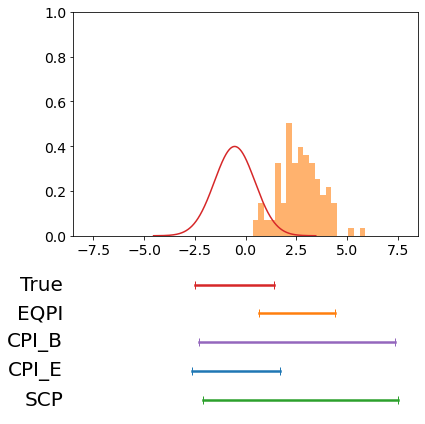

In [450]:
index = 0
pre_lag1 = 1 # position index of T-1 

# 資料準備 ----------------
# 第一張圖資料準備：上
## 常態分佈
mean = true_data_all_test[index, pre_lag1, 0].flatten() * 0.8
std_dev = 1
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

## 直方圖
data = pred_data_test[:, index, 0, 0].flatten()

# 第二張圖資料準備：下
L_true = true_data_all_test[index,pre_lag1,0]*0.8 - 1.96
U_true = true_data_all_test[index,pre_lag1,0]*0.8 + 1.96

L_model = L_star_model[index,0,0]
U_model = U_star_model[index,0,0]

L_scp = L_star_scp[index,0,0]
U_scp = U_star_scp[index,0,0]

L_both = L_star_both[index,0,0]
U_both = U_star_both[index,0,0]

L_each = L_star_each[index,0,0]
U_each = U_star_each[index,0,0]

intervals = {
    'True': (L_true, U_true),
    'EQPI': (L_model, U_model),
    'CPI_B': (L_both, U_both),
    'CPI_E': (L_each, U_each),
    'SCP': (L_scp, U_scp)
}


# 畫圖 ----------------

# 创建 subplot 网格，1 行 2 列，共享 x 轴
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})
# 設定顏色
colors = ['tab:red', 'tab:orange', 'tab:purple', 'tab:blue', 'tab:green']  # 颜色列表
# 找最小的 x for 第二張圖的 text
# x_min = min([min(x), np.min(data)] + [item[0] for item in intervals.values()])
x_min = -8.5
# 第一張圖：绘制正态分布曲线和直方图
ax1.plot(x, y, label='True Cond. Dist. of Test Data', color=colors[0], alpha=1)
# ax1.axvline(x=true_data_test[index, 0, 0], color=colors[0], linestyle='--', label='Test Data')
ax1.hist(data, bins=20, density=True, alpha=0.6, label='Histogram of Predictions', color=colors[1])
ax1.set_ylim(0, 1)# 设置 y 轴范围
ax1.set_xlim(-8.5, 8.5)# 设置 y 轴范围

# 第一張圖調整
ax1.xaxis.tick_bottom()  # 将 x 轴刻度保持在底部
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=14)  # 显示 x 轴刻度
ax1.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=14)

# ax1.legend(frameon=False, fancybox=True, facecolor='none', fontsize = 12, loc = 'upper left')


# 第二張圖：畫 intervals
for i, (label, (start, end)) in enumerate(intervals.items()):
    k = 0.5*(len(intervals) - i - 1)
    ax2.plot([start, end], [k, k], marker='|', markersize=8, color = colors[i], lw = 2.5)
    ax2.text(x_min-0.5, k, label, va='center', ha='right', fontsize=20)

# 第二張圖調整
ax2.set_ylim(-0.3, 2.3)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

# 调整子图间的垂直间距
plt.subplots_adjust(hspace=0.1)  # 设置子图的垂直间距为0

# 添加图例
plt.tight_layout()

# 保存图形
filename = 'PI_'+interval_case+'.png'
path = os.path.join(folder+foldername, filename)
plt.savefig(path, dpi=300, bbox_inches='tight')

# show
plt.show()

## Average length

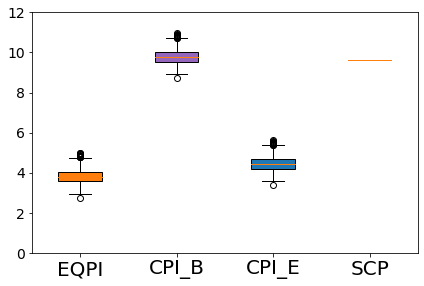

In [451]:
len_model = U_star_model - L_star_model

len_scp =  U_star_scp - L_star_scp

len_both = U_star_both - L_star_both

len_each = U_star_each - L_star_each

# 將數據存入列表中，準備繪製 boxplot
data = [len_model.flatten(), len_both.flatten(), len_each.flatten(), len_scp.flatten()]

colors = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green']  # 颜色列表

# 創建一個圖，並繪製 boxplot
plt.figure(figsize=(6, 4))
box = plt.boxplot(data, patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# 添加標籤
plt.xticks([1, 2, 3, 4], ['EQPI', 'CPI_B', 'CPI_E', 'SCP'], fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.title('')
plt.tight_layout()
plt.ylim(0,12)

# 保存图形
filename = 'AvgLen_'+interval_case+'.png'
path = os.path.join(folder+foldername, filename)
plt.savefig(path, dpi=300, bbox_inches='tight')
# show 
plt.show()

## Coverage rate

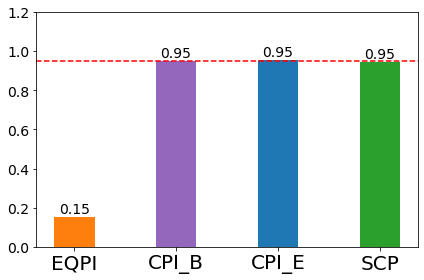

In [452]:
# 創建四個值對應 'Model', 'SCP', 'Cal_both', 'Cal_each'
values = [CR_test_model.item(), CR_test_both.item(), CR_test_each.item(), CR_test_scp.item()]  # 這裡假設一些示範數據值
labels = ['EQPI', 'CPI_B', 'CPI_E', 'SCP']

# 繪製長條圖，使用四個不同的顏色
colors = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green']  # 颜色列表

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors, width=0.4)  # 調整 bar 的寬度

# 添加紅色和黑色的水平線
plt.axhline(y=0.95, color='red', linestyle='--', label='y=0.95')
# plt.axhline(y=1, color='black', linestyle='--', label='y=1')

# 添加数值在柱状图上方，并放置在红线附近
for i, value in enumerate(values):
    plt.text(i, values[i] + 0.02, f'{value:.2f}', ha='center', fontsize=14, color='black')


# 設定 y 軸範圍
plt.ylim(0, 1.2)

# 添加標籤和標題
plt.ylabel('')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 20)
plt.title('')
plt.tight_layout()

# 保存图形
filename = 'CR_'+interval_case+'.png'
path = os.path.join(folder+foldername, filename)
plt.savefig(path, dpi=300, bbox_inches='tight')

# show
plt.show()